# <font color='red'>**Sequence to sequence implementation**</font>

## 1: Simple Encoder and Decoder


<font color='blue'>**Load the data**</font>

In [98]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
import pandas as pd
from tqdm import tqdm
import tensorflow as tf

data = open('ita.txt', 'r', encoding = 'utf-8').read().split('\n')
print(len(data))

341555


In [101]:
df = []
for i in range(100000):
    try:
        english, italin = data[i].split('\t')[0:2]
        df.append([english, italin])
    except:
        pass

df = pd.DataFrame(df, columns = ['english', 'italin'])
df.head()

,english,italin
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='blue'>**Preprocess data**</font>

In [102]:
import contractions
import re
import numpy as np
def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    for j, word in enumerate(text.split()):
        try:
    #         print(word)
            if len(re.findall('[^\w\d\ "]', word))> 0:
                text = re.sub(word, contractions.fix(word), text)
        
            text = re.sub('[^A-Za-z0-9èìò ]+', '', text)
        except:
            return np.nan
    return text

a = df.english.astype('str').apply(lambda x: preprocess(x))
b = df.italin.astype('str').apply(lambda x: preprocess(x))
df_preprocessed = pd.DataFrame(data = np.array([a, b]).T, columns = ['english', 'italin'])

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [103]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size, input_length= input_length)
        #Intialize Encoder LSTM layer
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)

    def call(self,input_sequence,states):
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c
    
    def initialize_states(self,batch_size):
        return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]


In [105]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        self.dec_embed = Embedding(input_dim = out_vocab_size, output_dim = embedding_size, input_length = input_length)
        #Intialize Decoder LSTM layer
        self.dec_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)
    
    def call(self,input_sequence, initial_states):
        embedding = self.dec_embed(input_sequence)
        output_state, dec_h, dec_c = self.dec_lstm(embedding, initial_state = initial_states)
        return output_state, dec_h, dec_c

In [107]:
class Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
    
    @tf.function
    def call(self, params, training = True):

        enc_inp, dec_inp = params[0], params[1]
        initial_state = self.encoder.initialize_states(batch_size)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        output, _, _ = self.decoder(dec_inp ,[enc_h, enc_c])
        return self.dense(output)

In [108]:
df_preprocessed['english_inp'] = '<sos> '+df_preprocessed['english']
df_preprocessed['english_out'] = df_preprocessed['english'] + ' <eos>'
df_preprocessed['italin'] = df_preprocessed['italin'].apply(lambda x: str(x))
df_preprocessed['italin'] = '<sos> '+df_preprocessed['italin']+' <eos>'

from sklearn.model_selection import train_test_split
train, test = train_test_split(df_preprocessed, test_size = 0.1, random_state = 0)
train, validation = train_test_split(train, test_size = 0.1, random_state = 0)

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italin'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values + train['english_out'].values)

In [110]:
len_eng = df_preprocessed['italin'].astype(str).apply(lambda x: len(x))
len_italin = df_preprocessed['english_inp'].astype(str).apply(lambda x: len(x))

In [111]:
for i in range(0,101,10):
    print(i,np.percentile(len_eng, i))
for i in range(90,101):
    print(i,np.percentile(len_eng, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(len_eng, i))

0 12.0
10 24.0
20 26.0
30 28.0
40 29.0
50 31.0
60 32.0
70 34.0
80 35.0
90 38.0
100 112.0
90 38.0
91 38.0
92 39.0
93 39.0
94 40.0
95 40.0
96 41.0
97 42.0
98 43.0
99 45.0
100 112.0
99.1 45.0
99.2 46.0
99.3 46.0
99.4 47.0
99.5 47.0
99.6 48.0
99.7 48.0
99.8 50.0
99.9 52.0
100 112.0


In [112]:
for i in range(0,101,10):
    print(i,np.percentile(len_italin, i))
for i in range(90,101):
    print(i,np.percentile(len_italin, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(len_italin, i))

0 8.0
10 18.0
20 20.0
30 21.0
40 22.0
50 23.0
60 24.0
70 25.0
80 25.0
90 26.0
100 45.0
90 26.0
91 26.0
92 26.0
93 26.0
94 27.0
95 27.0
96 27.0
97 27.0
98 27.0
99 28.0
100 45.0
99.1 28.0
99.2 28.0
99.3 28.0
99.4 28.0
99.5 28.0
99.6 28.0
99.7 28.0
99.8 29.0
99.9 29.0
100 45.0


In [113]:
max_len_eng = 0
eng_vocab = set()
for sent in df_preprocessed['english_inp'].values+df_preprocessed['english_out'].values:
    length = len(sent.split())
    if length > max_len_eng:
        max_len_eng = length
    for word in sent.split():
        eng_vocab.add(word)
eng_vocab_size = len(eng_vocab)

max_len_ita = 0
ita_vocab = set()
for sent in df_preprocessed['italin']:
    length = len(sent.split())
    if length > max_len_ita:
        max_len_ita = length
    for word in sent.split():
        ita_vocab.add(word)
ita_vocab_size = len(ita_vocab)

In [114]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng):
        self.encoder_inps = data['italin'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len_ita = max_len_ita
        self.max_len_eng = max_len_eng

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_ita, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_eng, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
#         print(batch[0].shape, batch[1].shape, batch[2].shape)
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[tf.convert_to_tensor(batch[0]), tf.convert_to_tensor(batch[1])], tf.convert_to_tensor(batch[2])])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [115]:
embeddings_index = dict()
f = open('glove.6B.300d.txt', encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [116]:
embedding_matrix = np.zeros((eng_vocab_size, 300))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(ord)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [117]:
from tensorflow.keras.callbacks import*
import os
import datetime
batch_size=32
lstm_size=128
max_len_eng = 50
max_len_ita = 29
embedding_dim = 300
dense_units = 256

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
val_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size)

In [118]:
model = Encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, max_len_ita, max_len_eng, dense_units)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('seq2seq', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(),
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
2531/2531 [==============================] - ETA: 0s - loss: 0.5123
Epoch 00001: val_loss improved from inf to 0.33803, saving model to seq2seq
2531/2531 [==============================] - 431s 170ms/step - loss: 0.5123 - val_loss: 0.3380
Epoch 2/50
2531/2531 [==============================] - ETA: 0s - loss: 0.2979- ETA: 0s - loss: 0.29
Epoch 00002: val_loss improved from 0.33803 to 0.26173, saving model to seq2seq
2531/2531 [==============================] - 449s 178ms/step - loss: 0.2979 - val_loss: 0.2617
Epoch 3/50
2531/2531 [==============================] - ETA: 0s - loss: 0.2302
Epoch 00003: val_loss improved from 0.26173 to 0.20859, saving model to seq2seq
2531/2531 [==============================] - 430s 170ms/step - loss: 0.2302 - val_loss: 0.2086
Epoch 4/50
2531/2531 [==============================] - ETA: 0s - loss: 0.1780
Epoch 00004: val_loss improved from 0.20859 to 0.16905, saving model to seq2seq
2531/2531 [==============================] - 428s 169ms/step 

In [119]:
class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self,*params):
        super().__init__()
        #Create encoder object
        self.encoder = Encoder(inp_vocab_size = params[0], embedding_size = params[2], lstm_size = params[3], input_length = params[4])
        #Create decoder object
        self.decoder = Decoder(out_vocab_size = params[1], embedding_size = params[2], lstm_size = params[3], input_length = params[5])
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(params[1], activation='softmax')
    
    def call(self, params, training = True):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([tknizer_eng.word_index['<sos>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        for t in range(max_len_eng):  
            pred, dec_h,dec_c = self.decoder(pred, [dec_h, dec_c])
            pred = self.dense(pred)
            pred = tf.argmax(pred, axis = -1)
            all_pred.append(pred)
        return all_pred

In [120]:
pred_model = pred_Encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, max_len_ita, max_len_eng, dense_units)
pred_model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy')
pred_model.load_weights('seq2seq')

In [121]:
def predict(input_sequence):
    seq = preprocess(input_sequence)
    seq = '<sos> '+seq+' <eos>'
    seq = tknizer_ita.texts_to_sequences([seq])
    seq = pad_sequences(seq, maxlen=max_len_ita, padding='post', dtype = np.int32)
    pred = pred_model.predict(tf.expand_dims(seq, 0))
    output = []
    for i in pred:
        word = tknizer_eng.index_word[i[0][0]]
        if word == '<eos>':
            break
        output.append(word)
    return ' '.join(output)

In [122]:
sentence = train['italin'].values[0][6:-6]
print('input : ', sentence)
result = predict(sentence)
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  sono brave persone
predicted output :  they are good people
actual output : they are good people


In [123]:
sentence = train['italin'].values[1000][6:-6]
print('input : ', sentence)
result = predict(sentence)
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

input :  cercherò di essere pi gentile
predicted output :  i will try to be nicer
actual output : I will try to be nicer


In [125]:
from nltk.translate.bleu_score import sentence_bleu
score =0
for i in range(1000):
    sentence = test['italin'].values[i][6:-6]
    reference = test['english'].values[i]
    pred = predict(sentence)
    score+= sentence_bleu([reference.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.38799303126017415


## 2: Seq2Seq with Attention mechanisum

<font color='blue'>**Encoder**</font>

In [31]:
from tensorflow.keras.layers import *
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.enc_embed = Embedding(input_dim = inp_vocab_size, output_dim = embedding_size)
        #Intialize Encoder LSTM layer
        self.enc_lstm = LSTM(lstm_size, return_sequences = True, return_state = True)
        
    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        embedding = self.enc_embed(input_sequence)
        output_state, enc_h, enc_c = self.enc_lstm(embedding, initial_state = states)
        return output_state, enc_h, enc_c
    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      return [tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))]


<font color='blue'>**Attention Mechanism**</font>

In [33]:
from tensorflow.keras.layers import *
class Attention(tf.keras.layers.Layer):

    def __init__(self,scoring_function, att_units):
        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'dot':
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'general':
          # Intialize variables needed for General score function here
            self.W = Dense(att_units)
            self.dot = Dot(axes = (1, 2))
        elif scoring_function == 'concat':
          # Intialize variables needed for Concat score function here
            self.W1 = Dense(att_units)
            self.W2 = Dense(att_units)
            self.V = Dense(1)
    def call(self,decoder_hidden_state,encoder_output):
    
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), encoder_output]), (0, 2,1))
            
        elif self.scoring_function == 'general':
            # Implement General score function here
            mul = self.W(encoder_output)
            score = tf.transpose(self.dot([tf.transpose(decoder_hidden_state, (0, 2, 1)), mul]), (0, 2,1))
            
        elif self.scoring_function == 'concat':
            # Implement General score function here
            inter = self.W1(decoder_hidden_state) + self.W2(encoder_output)
            tan = tf.nn.tanh(inter)
            score = self.V(tan)
        attention_weights = tf.nn.softmax(score, axis =1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

<font color='blue'>**OneStepDecoder**</font>

In [35]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(OneStepDecoder, self).__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embed_dec = Embedding(input_dim = tar_vocab_size, output_dim = embedding_dim)
        self.lstm = LSTM(dec_units, return_sequences = True, return_state = True)
        self.attention = Attention(scoring_function = score_fun, att_units = att_units)
        self.fc = Dense(tar_vocab_size)
    
    def call(self,input_to_decoder, encoder_output, state_h,state_c):
        '''
            One step decoder mechanisim step by step:
          A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
          B. Using the encoder_output and decoder hidden state, compute the context vector.
          C. Concat the context vector with the step A output
          D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
          E. Pass the decoder output to dense layer(vocab size) and store the result into output.
          F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        embed = self.embed_dec(input_to_decoder)
        context_vect, attention_weights = self.attention(state_h, encoder_output)    
        final_inp = tf.concat([tf.expand_dims(context_vect, 1), embed], axis = -1)
        out, dec_h, dec_c = self.lstm(final_inp, [state_h, state_c])
        out = tf.reshape(out, (-1, out.shape[2]))
        output = self.fc(out)
        return output, dec_h, dec_c, attention_weights, context_vect

<font color='blue'>**Decoder**</font>

In [37]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.input_length = input_length
        self.out_vocab_size = out_vocab_size
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
        self.out_vocab_size = out_vocab_size
        
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        all_outputs = tf.TensorArray(dtype = tf.float32, size= input_to_decoder.shape[1])
        
        for timestep in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.one_step_decoder(input_to_decoder[:, timestep:timestep+1], 
                                                                                             encoder_output, 
                                                                                             decoder_hidden_state,
                                                                                             decoder_cell_state)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        return all_outputs
        
    

<font color='blue'>**Encoder Decoder model**</font>

In [39]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units, batch_size):
        #Intialize objects from encoder decoder
        super(encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    
    @tf.function
    def call(self, data):
        enc_inp, dec_inp = data[0], data[1]
        initial_state = self.encoder.initialize_states(self.batch_size)
        enc_output, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        all_outputs = tf.TensorArray(dtype = tf.float32, size= 50)
        
        dec_h = enc_h
        dec_c = enc_c
        for timestep in range(50):
            # Call onestepdecoder for each token in decoder_input
            output, dec_h, dec_c, _, _ = self.one_step_decoder(dec_inp[:, timestep:timestep+1], 
                                                               enc_output, 
                                                               dec_h,
                                                               dec_c)
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        # Return the tensor array
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        # return the decoder output
        return all_outputs

<font color='blue'>**Custom loss function**</font>

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [95]:
from tensorflow.keras.callbacks import*
import os
batch_size=128
lstm_size=128
max_len_eng = 50
max_len_ita = 29
embedding_dim = 100
att_units = 256

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
val_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size)

In [44]:
model = encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'dot', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('Attention_dot', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

In [45]:
model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(),
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
632/632 [==============================] - ETA: 0s - loss: 0.4580
Epoch 00001: val_loss improved from inf to 0.40010, saving model to Attention_dot
632/632 [==============================] - 254s 403ms/step - loss: 0.4580 - val_loss: 0.4001
Epoch 2/50
632/632 [==============================] - ETA: 0s - loss: 0.3751
Epoch 00002: val_loss improved from 0.40010 to 0.34164, saving model to Attention_dot
632/632 [==============================] - 239s 378ms/step - loss: 0.3751 - val_loss: 0.3416
Epoch 3/50
632/632 [==============================] - ETA: 0s - loss: 0.3218
Epoch 00003: val_loss improved from 0.34164 to 0.30097, saving model to Attention_dot
632/632 [==============================] - 241s 381ms/step - loss: 0.3218 - val_loss: 0.3010
Epoch 4/50
632/632 [==============================] - ETA: 0s - loss: 0.2860
Epoch 00004: val_loss improved from 0.30097 to 0.27541, saving model to Attention_dot
632/632 [==============================] - 244s 386ms/step - loss: 0.2860

In [46]:
class pred_Encoder_decoder(tf.keras.Model): 
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_dim, enc_units, dec_units, max_len_ita, max_len_eng, score_fun, att_units):
        #Intialize objects from encoder decoder
        super(pred_Encoder_decoder, self).__init__()
        self.encoder = Encoder(inp_vocab_size, embedding_dim, enc_units, max_len_ita)
        self.one_step_decoder = OneStepDecoder(out_vocab_size, embedding_dim, max_len_eng, dec_units ,score_fun ,att_units)
        self.batch_size = batch_size
    def call(self, params):
        enc_inp = params[0]
        initial_state = self.encoder.initialize_states(1)
        output_state, enc_h, enc_c = self.encoder(enc_inp, initial_state)
        pred = tf.expand_dims([tknizer_eng.word_index['<sos>']], 0)
        dec_h = enc_h
        dec_c = enc_c
        all_pred = []
        all_attention = []
        for t in range(50):  
            pred, dec_h,dec_c, attention, _ = self.one_step_decoder(pred, output_state, dec_h, dec_c)
            pred = tf.argmax(pred, axis = -1)
            all_pred.append(pred)
            pred = tf.expand_dims(pred, 0)
            all_attention.append(attention)
        return all_pred, all_attention

In [96]:
pred_model = pred_Encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'dot', att_units)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.load_weights('Attention_dot')

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [49]:
def predict(input_sequence):
    seq = preprocess(input_sequence)
    seq = '<sos> '+seq+' <eos>'
    seq = tknizer_ita.texts_to_sequences([seq])
    seq = pad_sequences(seq, maxlen=max_len_ita, padding='post', dtype = np.int32)
    pred, attention_weights = pred_model.predict(tf.expand_dims(seq, 0))
    output = []
    for i in pred:
        word = tknizer_eng.index_word[i[0]]
        if word == '<eos>':
            break
        output.append(word)
    return ' '.join(output), np.squeeze(np.squeeze(np.array(attention_weights), 1), -1)

<font color='blue'>**Predict the sentence translation**</font>

input :  sono brave persone


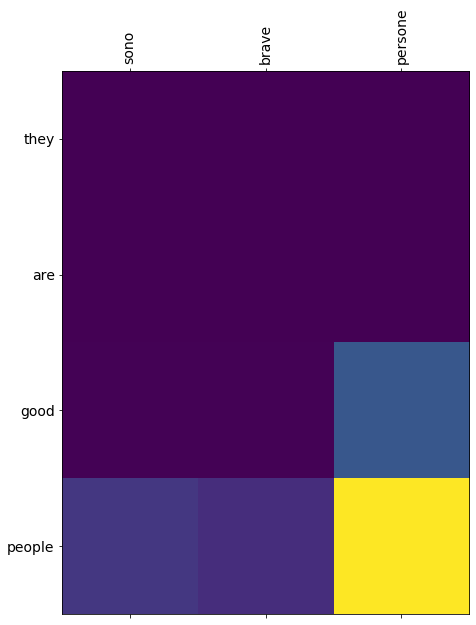

predicted output :  they are good people
actual output : they are good people


In [50]:
sentence = train['italin'].values[0][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('predicted output : ',result)
print('actual output :', train['english'].values[0])

input :  cercherò di essere pi gentile


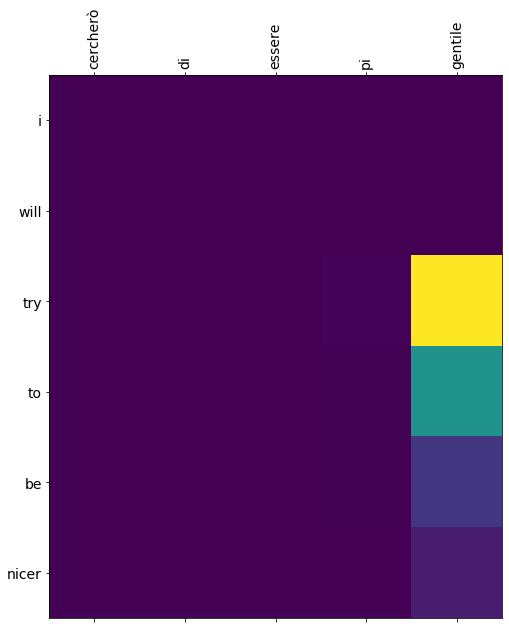

predicted output :  i will try to be nicer
actual output : I will try to be nicer


In [51]:
sentence = train['italin'].values[1000][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('predicted output : ',result)
print('actual output :', train['english'].values[1000])

<font color='blue'>**Calculate BLEU score**</font>

In [97]:
from nltk.translate.bleu_score import sentence_bleu
score =0
for i in range(1000):
    sentence = test['italin'].values[i][6:-6]
    reference = test['english'].values[i]
    pred, _ = predict(sentence)
    score+= sentence_bleu([reference.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.37088297078207916


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [89]:
from tensorflow.keras.callbacks import*
import os
import datetime

batch_size=128
lstm_size=256
embedding_dim = 100

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
val_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size)

In [55]:
model = encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'general', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('Attention_general', save_best_only= True, verbose = 1),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

In [56]:
model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(),
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
632/632 [==============================] - ETA: 0s - loss: 0.4437
Epoch 00001: val_loss improved from inf to 0.39343, saving model to Attention_general
632/632 [==============================] - 291s 460ms/step - loss: 0.4437 - val_loss: 0.3934
Epoch 2/50
632/632 [==============================] - ETA: 0s - loss: 0.3656
Epoch 00002: val_loss improved from 0.39343 to 0.32708, saving model to Attention_general
632/632 [==============================] - 273s 432ms/step - loss: 0.3656 - val_loss: 0.3271
Epoch 3/50
632/632 [==============================] - ETA: 0s - loss: 0.2969
Epoch 00003: val_loss improved from 0.32708 to 0.27086, saving model to Attention_general
632/632 [==============================] - 273s 432ms/step - loss: 0.2969 - val_loss: 0.2709
Epoch 4/50
632/632 [==============================] - ETA: 0s - loss: 0.2465
Epoch 00004: val_loss improved from 0.27086 to 0.23024, saving model to Attention_general
632/632 [==============================] - 272s 430ms/ste

In [93]:
pred_model = pred_Encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'general', att_units)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.load_weights('Attention_general')

input :  sono brave persone


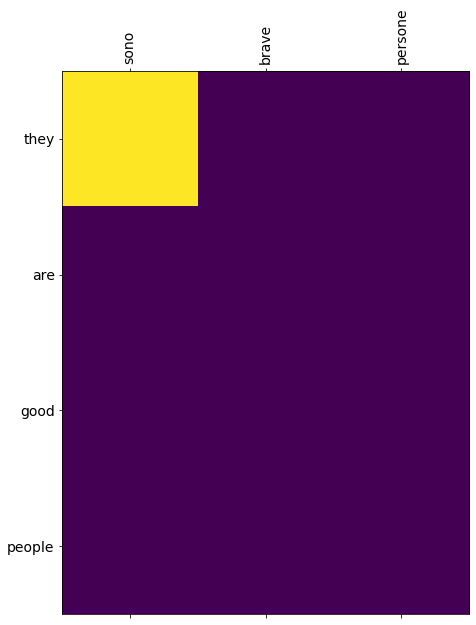

output :  they are good people


In [58]:
sentence = train['italin'].values[0][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('output : ',result)

input :  cercherò di essere pi gentile


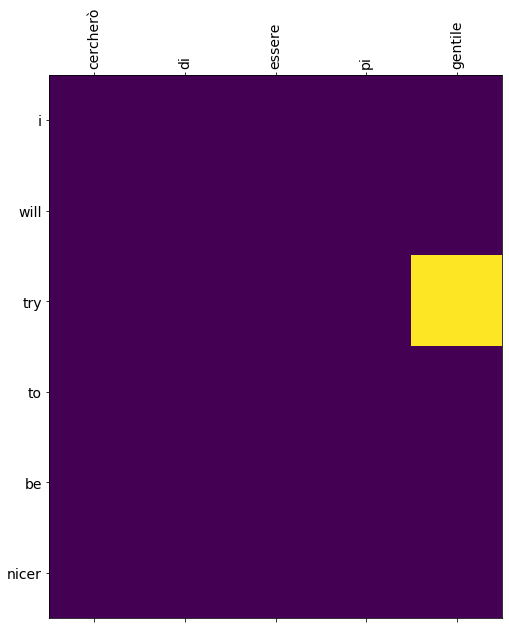

output :  i will try to be nicer


In [59]:
sentence = train['italin'].values[1000][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('output : ',result)

In [94]:
from nltk.translate.bleu_score import sentence_bleu
score =0
for i in range(1000):
    sentence = test['italin'].values[i][6:-6]
    reference = test['english'].values[i]
    pred, _ = predict(sentence)
    score+= sentence_bleu([reference.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.39123319557452246


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [61]:
from tensorflow.keras.callbacks import*
import os
batch_size=64
lstm_size=128
embedding_dim = 100

train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
test_dataset  = Dataset(test, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)
val_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, max_len_ita, max_len_eng)

train_dataloader = Dataloder(train_dataset, batch_size=batch_size)
test_dataloader = Dataloder(test_dataset, batch_size=batch_size)
val_dataloader = Dataloder(val_dataset, batch_size = batch_size)

In [62]:
model = encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'concat', att_units, batch_size)
model.compile(optimizer = 'Adam', loss = loss_function)
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [ModelCheckpoint('Attention_concat', save_best_only= True),
             TensorBoard(log_dir = log_dir, histogram_freq=1, write_graph=True),
             EarlyStopping(patience = 5, verbose = 1),
             ReduceLROnPlateau(patience = 3, verbose = 1)]

In [63]:
model.fit(x = train_dataloader, 
          steps_per_epoch = train_dataloader.__len__(),
          validation_data = val_dataloader,
          validation_steps = val_dataloader.__len__(),
          epochs = 50,
          verbose = 1,
          callbacks = callbacks)

Epoch 1/50
1265/1265 [==============================] - 476s 376ms/step - loss: 0.4247 - val_loss: 0.3481
Epoch 2/50
1265/1265 [==============================] - 455s 359ms/step - loss: 0.3086 - val_loss: 0.2701
Epoch 3/50
1265/1265 [==============================] - 450s 356ms/step - loss: 0.2430 - val_loss: 0.2236
Epoch 4/50
1265/1265 [==============================] - 459s 363ms/step - loss: 0.2004 - val_loss: 0.1920
Epoch 5/50
1265/1265 [==============================] - 455s 360ms/step - loss: 0.1661 - val_loss: 0.1641
Epoch 6/50
1265/1265 [==============================] - 454s 359ms/step - loss: 0.1361 - val_loss: 0.1415
Epoch 7/50
1265/1265 [==============================] - 453s 358ms/step - loss: 0.1100 - val_loss: 0.1216
Epoch 8/50
1265/1265 [==============================] - 453s 358ms/step - loss: 0.0881 - val_loss: 0.1058
Epoch 9/50
1265/1265 [==============================] - 456s 360ms/step - loss: 0.0707 - val_loss: 0.0941
Epoch 10/50
1265/1265 [=======================

In [64]:
pred_model = pred_Encoder_decoder(ita_vocab_size, eng_vocab_size, embedding_dim, lstm_size, lstm_size, max_len_ita, max_len_eng, 'concat', att_units)
pred_model.compile(optimizer = 'Adam', loss = loss_function)
pred_model.load_weights('Attention_concat')

input :  sono brave persone


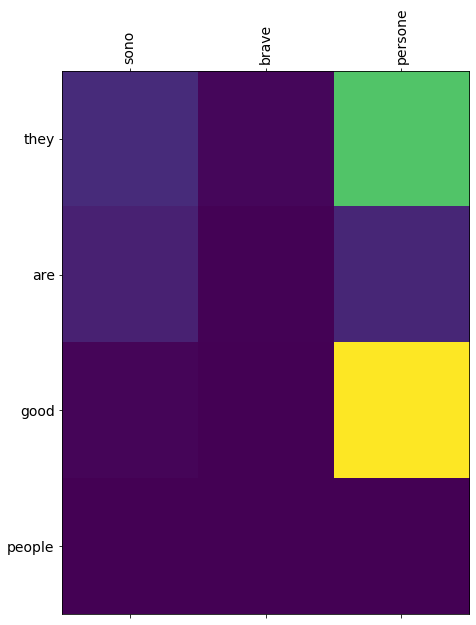

output :  they are good people


In [65]:
sentence = train['italin'].values[0][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('output : ',result)

input :  cercherò di essere pi gentile


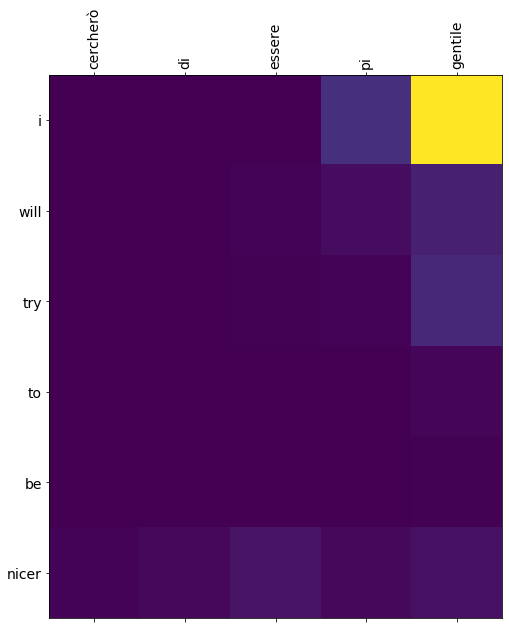

output :  i will try to be nicer


In [66]:
sentence = train['italin'].values[1000][6:-6]
print('input : ', sentence)
result, attention_plot = predict(sentence)
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))
print('output : ',result)

In [81]:
from nltk.translate.bleu_score import sentence_bleu
score =0
for i in range(1000):
    sentence = test['italin'].values[i][6:-6]
    reference = test['english'].values[i]
    pred, _ = predict(sentence)
    score+= sentence_bleu([reference.split()], pred.split())
print('Bleu Score : {}'.format(score/1000))

Bleu Score : 0.39759090788619267


# Conclusion

> 1. Attention mechanism with score function as 'concat' converges faster than score function of 'general' and 'dot'.
> 2. concat convergence > general convergence > dot convergence